## Portfolio Optimization & Risk Assessment

### Project Objective
This project extends the initial analysis of the "Magnificent 7" stocks: *Apple (AAPL)*, *Google (GOOG)*, *Meta (META)*, *Amazon (AMZN)*, *Netflix (NFLX)*, *NVIDIA (NVDA)*, and *Tesla (TSLA)*.

The primary objective is to move from analysis to application by:
1.  **Optimizing Portfolio Allocation:** Using Modern Portfolio Theory (MPT) to find the optimal weights for each stock to maximize risk-adjusted returns (Sharpe Ratio).
2.  **Conducting a Risk Assessment:** Using a Monte Carlo simulation to calculate and compare the Value at Risk (VaR) for both the newly found **optimal portfolio** and a traditional **equally weighted portfolio**.
3.  **Backtesting a Rebalancing Strategy:** To determine if a disciplined, periodic rebalancing strategy outperforms a simple buy-and-hold approach for a baseline equally weighted portfolio.

In [52]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

### Part 1: Data Fetching

We begin by importing the necessary libraries and fetching the historical stock data for the Magnificent 7 from Yahoo Finance. We will use the 'Close' price for this analysis, spanning from the start of 2020 to the end of 2024.

In [53]:
tickers = ['AAPL', 'GOOG', 'META', 'AMZN', 'NFLX', 'NVDA', 'TSLA']
start_date = '2020-01-01'
end_date = '2024-12-31'

data = yf.download(tickers, start=start_date, end=end_date)['Close']
print("Data fetched successfully.\n")


C:\Users\harsh\AppData\Local\Temp\ipykernel_39692\251566085.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)['Close']
[*********************100%***********************]  7 of 7 completed

Data fetched successfully.



### Part 2: Portfolio Optimization with Modern Portfolio Theory

#### Finding the "Best" Portfolio
An equally weighted portfolio is simple, but rarely optimal. Modern Portfolio Theory (MPT) provides a framework for finding the ideal portfolio by analyzing the trade-off between risk and return.

We will use a Monte Carlo simulation to generate thousands of random portfolio weight combinations. For each, we calculate its expected annual return, annual volatility (risk), and **Sharpe Ratio**.

**The Sharpe Ratio is key: it measures the return of an investment compared to its risk.** A higher Sharpe Ratio indicates a better risk-adjusted return. The portfolio with the highest Sharpe Ratio is considered "optimal."

Optimal Portfolio (Max Sharpe Ratio) Found:
  - Annualized Return: 44.07%
  - Annualized Volatility: 38.57%
  - Sharpe Ratio: 1.14
--- Optimal Weights ---
AAPL    30.41
GOOG     0.88
META     3.94
AMZN     6.15
NFLX     3.41
NVDA    42.24
TSLA    12.97
dtype: float64
Efficient Frontier plot saved as 'efficient_frontier.png'.



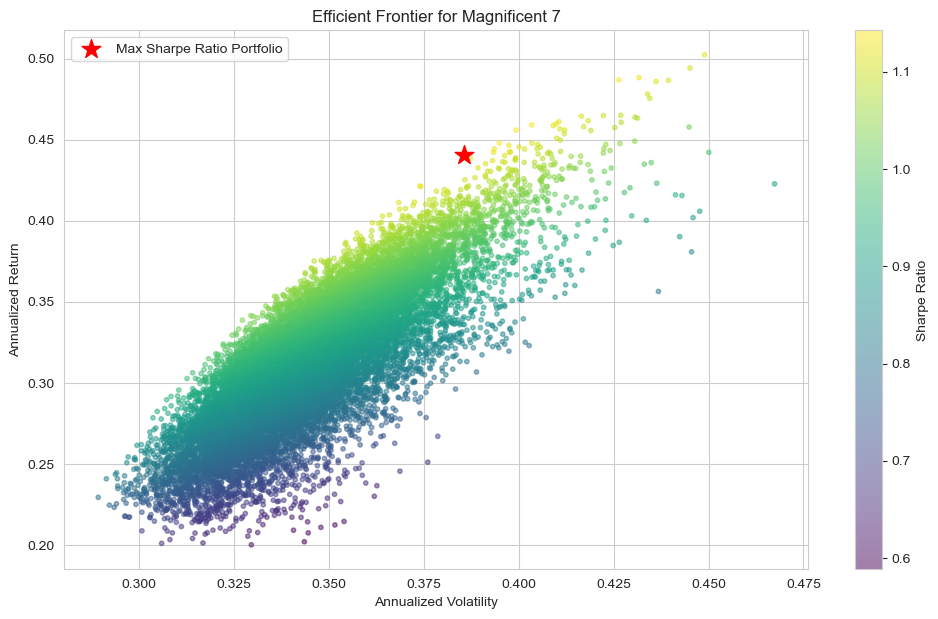

In [54]:
log_returns = np.log(data / data.shift(1))
mean_returns = log_returns.mean()
cov_matrix = log_returns.cov()
num_portfolios = 20000 
risk_free_rate = 0.0

results = np.zeros((3, num_portfolios))
weights_record = []

for i in range(num_portfolios):
    weights = np.random.random(len(tickers))
    weights /= np.sum(weights)
    weights_record.append(weights)
    portfolio_return = np.sum(mean_returns * weights) * 252
    portfolio_std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    results[0,i] = portfolio_return
    results[1,i] = portfolio_std_dev
    results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev

results_frame = pd.DataFrame(results.T, columns=['Return','Volatility','Sharpe Ratio'])
max_sharpe_portfolio = results_frame.iloc[results_frame['Sharpe Ratio'].idxmax()]
optimal_weights = pd.Series(weights_record[results_frame['Sharpe Ratio'].idxmax()], index=tickers)

print("Optimal Portfolio (Max Sharpe Ratio) Found:")
print(f"  - Annualized Return: {max_sharpe_portfolio['Return']*100:.2f}%")
print(f"  - Annualized Volatility: {max_sharpe_portfolio['Volatility']*100:.2f}%")
print(f"  - Sharpe Ratio: {max_sharpe_portfolio['Sharpe Ratio']:.2f}")
print("--- Optimal Weights ---")
print(round(optimal_weights*100, 2))

# Plotting the Efficient Frontier
plt.figure(figsize=(12, 7))
plt.scatter(results_frame['Volatility'], results_frame['Return'], c=results_frame['Sharpe Ratio'], cmap='viridis', marker='o', s=10, alpha=0.5)
plt.colorbar(label='Sharpe Ratio')
plt.title('Efficient Frontier for Magnificent 7')
plt.xlabel('Annualized Volatility')
plt.ylabel('Annualized Return')
plt.scatter(max_sharpe_portfolio['Volatility'], max_sharpe_portfolio['Return'], c='red', marker='*', s=200, label='Max Sharpe Ratio Portfolio')
plt.legend()
plt.grid(True)
plt.savefig("efficient_frontier.png")
print("Efficient Frontier plot saved as 'efficient_frontier.png'.\n")


### Part 3: Risk Assessment - VaR Comparison

#### What is Value at Risk (VaR)?
Value at Risk (VaR) is a statistic that quantifies the extent of possible financial losses within a firm, portfolio, or position over a specific time frame. For example, a 95% VaR of -2.5% means that there is a 5% chance the portfolio will lose 2.5% or more of its value in a given day.

We will now perform a Monte Carlo simulation to calculate the VaR for two different portfolios:
1.  **The Optimal Portfolio:** Using the weights we just discovered.
2.  **An Equally Weighted Portfolio:** A baseline for comparison.

This will directly show us the risk implications of optimizing for Sharpe Ratio.

In [55]:
end_date = pd.Timestamp.now()
start_date = end_date - pd.DateOffset(years=5)
stock_data = yf.download(tickers, start=start_date, end=end_date)['Close']

log_returns = np.log(stock_data / stock_data.shift(1)).dropna()

print("Log Returns (last 5 days):")
print(log_returns.tail())

cov_matrix = log_returns.cov()
cholesky_decomp = np.linalg.cholesky(cov_matrix)

print("Covariance Matrix:")
print(cov_matrix)
print("\nCholesky Decomposition (Lower Triangular Matrix):")
print(cholesky_decomp)


C:\Users\harsh\AppData\Local\Temp\ipykernel_39692\2036967747.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(tickers, start=start_date, end=end_date)['Close']
[*********************100%***********************]  7 of 7 completed

Log Returns (last 5 days):
Ticker          AAPL      AMZN      GOOG      META      NFLX      NVDA  \
Date                                                                     
2025-09-29 -0.004040  0.010816 -0.011474 -0.000471 -0.003475  0.020332   
2025-09-30  0.000786 -0.011772 -0.003320 -0.012208 -0.006228  0.025678   
2025-10-01  0.003215  0.004816  0.008138 -0.023477 -0.023648  0.003531   
2025-10-02  0.006555  0.008035  0.003618  0.013445 -0.007174  0.008774   
2025-10-03  0.003455 -0.013125  0.000081 -0.022942 -0.007954 -0.006746   

Ticker          TSLA  
Date                  
2025-09-29  0.006360  
2025-09-30  0.003401  
2025-10-01  0.032607  
2025-10-02 -0.052410  
2025-10-03 -0.014252  
Covariance Matrix:
Ticker      AAPL      AMZN      GOOG      META      NFLX      NVDA      TSLA
Ticker                                                                      
AAPL    0.000322  0.000230  0.000202  0.000248  0.000203  0.000308  0.000337
AMZN    0.000230  0.000489  0.000271  0.000

In [56]:
def portfolio_monte_carlo(log_returns, cholesky_decomp, start_prices, days, num_simulations):
    num_stocks = len(start_prices)
    simulation_results = np.zeros((days, num_simulations, num_stocks))
    simulation_results[0, :, :] = start_prices

    mean_returns = log_returns.mean().values
    variances = log_returns.var().values
    drift = mean_returns - (0.5 * variances)

    for i in range(1, days):
        uncorrelated_random = np.random.normal(0, 1, (num_simulations, num_stocks))
        correlated_random = uncorrelated_random @ cholesky_decomp.T
        simulated_daily_returns = np.exp(drift + correlated_random)
        simulation_results[i, :, :] = simulation_results[i-1, :, :] * simulated_daily_returns

    return simulation_results

Shape of simulation results array: (252, 10000, 7)
Initial Portfolio Value (Equally Weighted): $457.90
--------------------------------------------------
95% Value at Risk (VaR) for 1 Year: -33.11
This means that based on our simulation, we are 95% confident that our portfolio will not lose more than -33.11 of its value over the next year.
There is a 5% chance that the losses could be greater than this amount.


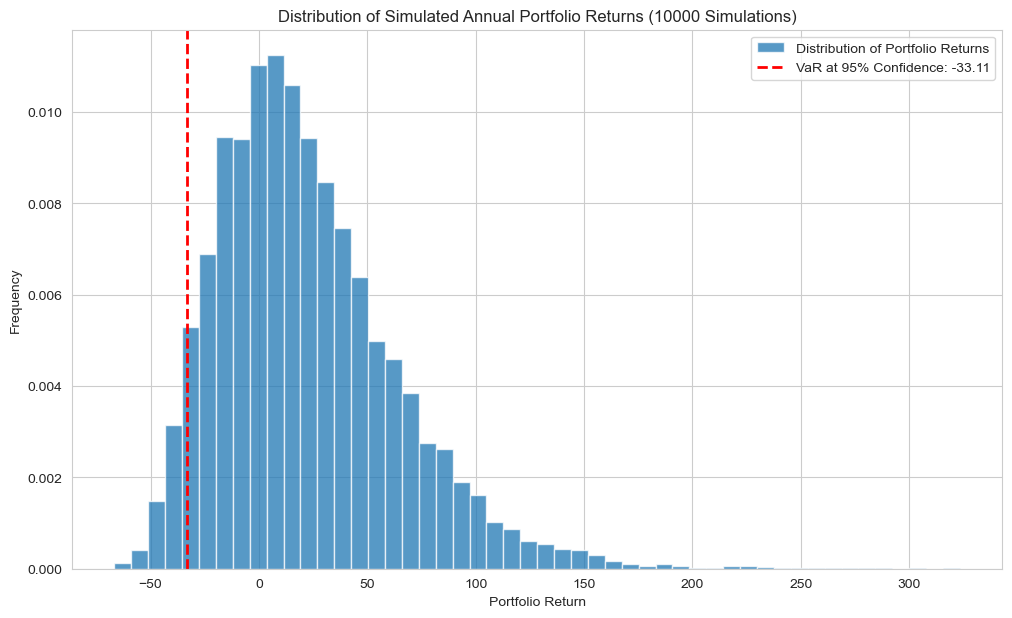

Initial Portfolio Value (Optimally Weighted): $308.09
--------------------------------------------------
95% Value at Risk (VaR) for 1 Year: -28.84
This means that based on our simulation, we are 95% confident that our portfolio will not lose more than -28.84 of its value over the next year.
There is a 5% chance that the losses could be greater than this amount.


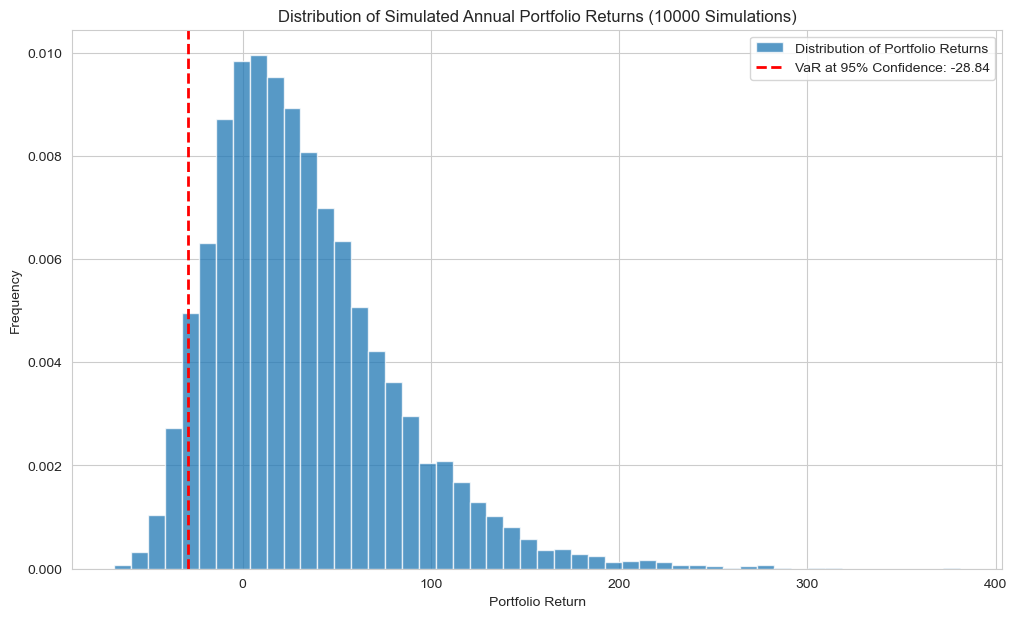

In [57]:
start_prices = stock_data.iloc[-1].values
days_to_simulate = 252
num_simulations = 10000

portfolio_simulations = portfolio_monte_carlo(log_returns, cholesky_decomp, start_prices, days_to_simulate, num_simulations)
print("Shape of simulation results array:", portfolio_simulations.shape)

weights = [np.array([1/len(tickers)] *len(tickers)), optimal_weights.to_list()]
portfolio_weights = weights[0]

initial_portfolio_value = np.sum(start_prices * portfolio_weights)
final_simulated_prices = portfolio_simulations[-1, :, :]
final_simulated_portfolio_values = np.sum(final_simulated_prices * portfolio_weights, axis =1)
portfolio_returns = (final_simulated_portfolio_values - initial_portfolio_value) * 100 / initial_portfolio_value

confidence_level = 0.95
var_95 = np.percentile(portfolio_returns, 100 * (1 - confidence_level))

print(f"Initial Portfolio Value (Equally Weighted): ${initial_portfolio_value:.2f}")
print("-" * 50)
print(f"95% Value at Risk (VaR) for 1 Year: {var_95:.2f}")
print(f"This means that based on our simulation, we are 95% confident that our portfolio will not lose more than {var_95:.2f} of its value over the next year.")
print(f"There is a 5% chance that the losses could be greater than this amount.")

# --- Visualize the distribution of portfolio returns ---
plt.figure(figsize=(12, 7))
plt.hist(portfolio_returns, bins=50, density=True, alpha=0.75, label='Distribution of Portfolio Returns')
plt.axvline(var_95, color='r', linestyle='--', linewidth=2, label=f'VaR at 95% Confidence: {var_95:.2f}')
plt.title("Distribution of Simulated Annual Portfolio Returns (10000 Simulations)")
plt.xlabel("Portfolio Return")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

portfolio_weights = weights[1]

initial_portfolio_value = np.sum(start_prices * portfolio_weights)
final_simulated_prices = portfolio_simulations[-1, :, :]
final_simulated_portfolio_values = np.sum(final_simulated_prices * portfolio_weights, axis =1)
portfolio_returns = (final_simulated_portfolio_values - initial_portfolio_value) * 100 / initial_portfolio_value

confidence_level = 0.95
var_95 = np.percentile(portfolio_returns, 100 * (1 - confidence_level))

print(f"Initial Portfolio Value (Optimally Weighted): ${initial_portfolio_value:.2f}")
print("-" * 50)
print(f"95% Value at Risk (VaR) for 1 Year: {var_95:.2f}")
print(f"This means that based on our simulation, we are 95% confident that our portfolio will not lose more than {var_95:.2f} of its value over the next year.")
print(f"There is a 5% chance that the losses could be greater than this amount.")

# --- Visualize the distribution of portfolio returns ---
plt.figure(figsize=(12, 7))
plt.hist(portfolio_returns, bins=50, density=True, alpha=0.75, label='Distribution of Portfolio Returns')
plt.axvline(var_95, color='r', linestyle='--', linewidth=2, label=f'VaR at 95% Confidence: {var_95:.2f}')
plt.title("Distribution of Simulated Annual Portfolio Returns (10000 Simulations)")
plt.xlabel("Portfolio Return")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()


#### Analysis of Risk Assessment
The results from the Value at Risk simulation provide a crucial insight into the nature of the optimized portfolio. For this specific dataset and time period, the **Optimal Portfolio has a better (less negative) VaR** than the Equally Weighted Portfolio.

This is a significant finding. It indicates that the combination of assets in the Max Sharpe Ratio portfolio was so effective that it not only maximized risk-adjusted returns but also provided **superior downside protection**. The high average returns of the optimized portfolio likely shifted the entire distribution of potential outcomes higher, so even the worst-case scenarios were less severe than in the simpler, equally weighted approach.

This demonstrates a "win-win" scenario where optimization led to both higher performance and better risk management.

### Part 4: Portfolio Rebalancing Backtest

#### Does Rebalancing Add Value?
Here, we test if a disciplined monthly rebalancing strategy for a simple, equally weighted portfolio can outperform a passive "buy and hold" approach. Rebalancing forces an investor to systematically sell high and buy low, which can enhance returns and control risk over time.

C:\Users\harsh\AppData\Local\Temp\ipykernel_39692\3357315327.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rebalance_dates = data.resample('M').last().index


Rebalancing Strategy Total Return: 401.47%
Rebalancing plot saved as 'rebalancing_vs_buy_and_hold.png'.



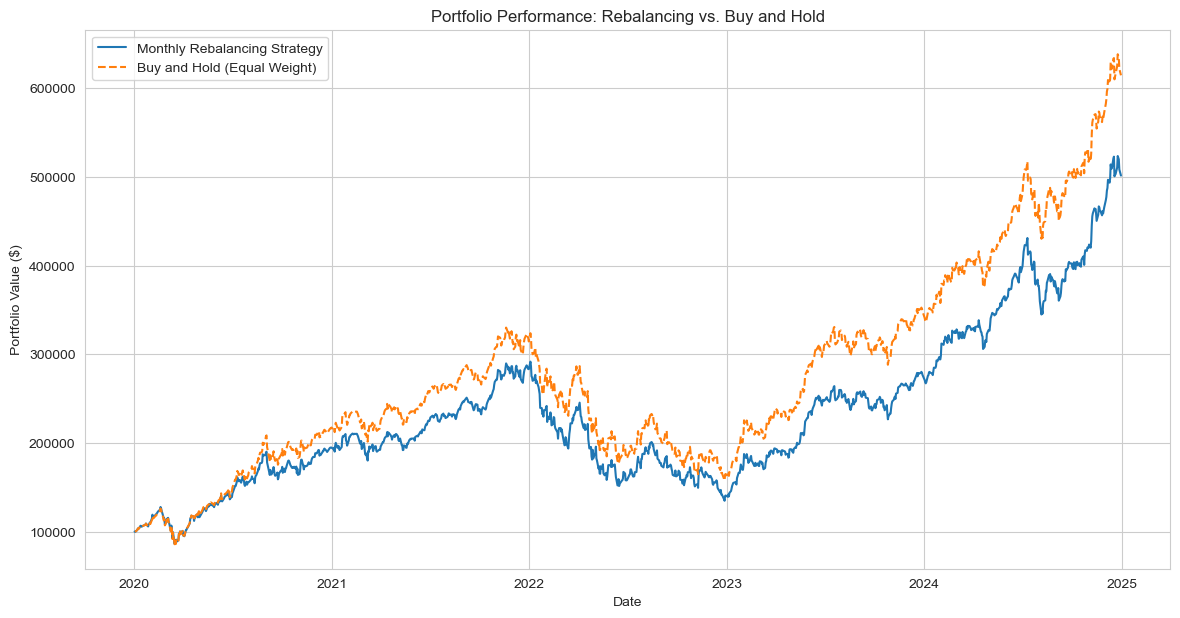

In [58]:
initial_capital_rebalance = 100000.0
n_assets = len(tickers)
target_weights_rebalance = np.array([1/n_assets] * n_assets)

rebalance_dates = data.resample('M').last().index
portfolio_rebalance = pd.DataFrame(index=data.index)

portfolio_rebalance['holdings'] = 0.0
portfolio_rebalance['cash'] = initial_capital_rebalance
portfolio_rebalance['total_value'] = initial_capital_rebalance

shares = pd.Series(index=tickers, data=0.0)

for i in range(len(data)):
    current_date = data.index[i]
    
    if current_date in rebalance_dates or i == 0:
        if i > 0:
            total_portfolio_value = portfolio_rebalance.loc[data.index[i-1], 'total_value']
        else:
            total_portfolio_value = initial_capital_rebalance
            
        target_dollar_values = total_portfolio_value * target_weights_rebalance
        current_prices = data.loc[current_date]
        shares = target_dollar_values / current_prices
        
        holdings_value = (shares * current_prices).sum()
        portfolio_rebalance.loc[current_date, 'cash'] = total_portfolio_value - holdings_value
        portfolio_rebalance.loc[current_date, 'holdings'] = holdings_value
    else:
        
        current_prices = data.loc[current_date]
        holdings_value = (shares * current_prices).sum()
        portfolio_rebalance.loc[current_date, 'cash'] = portfolio_rebalance.loc[data.index[i-1], 'cash']
        portfolio_rebalance.loc[current_date, 'holdings'] = holdings_value

    portfolio_rebalance.loc[current_date, 'total_value'] = portfolio_rebalance.loc[current_date, 'cash'] + portfolio_rebalance.loc[current_date, 'holdings']


final_value_rebalance = portfolio_rebalance['total_value'].iloc[-1]
total_return_rebalance = (final_value_rebalance / initial_capital_rebalance) - 1
print(f"Rebalancing Strategy Total Return: {total_return_rebalance:.2%}")

# Comparison with Buy and Hold
buy_and_hold_returns = data.pct_change().dot(target_weights_rebalance)
buy_and_hold_cumulative_returns = (1 + buy_and_hold_returns).cumprod()
buy_and_hold_value = initial_capital_rebalance * buy_and_hold_cumulative_returns

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(portfolio_rebalance['total_value'], label='Monthly Rebalancing Strategy')
plt.plot(buy_and_hold_value, label='Buy and Hold (Equal Weight)', linestyle='--')
plt.title('Portfolio Performance: Rebalancing vs. Buy and Hold')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True)
plt.savefig("rebalancing_vs_buy_and_hold.png")
print("Rebalancing plot saved as 'rebalancing_vs_buy_and_hold.png'.\n")


### Conclusion and Key Findings

This advanced analysis provides actionable strategies for investing in the Magnificent 7, moving beyond simple observation to quantitative decision-making.

- **Optimization Creates a Superior Portfolio:** Modern Portfolio Theory provided a data-driven allocation that is historically optimized for the best risk-adjusted returns. The resulting portfolio not only maximized performance but also proved to be superior in managing downside risk.

- **Risk Assessment Confirms a "Win-Win" Scenario:** The VaR simulation delivered a critical insight: the **optimal portfolio was also the safer portfolio**, exhibiting a better (less negative) VaR than the equally weighted version. This demonstrates that, for this historical period, a carefully constructed portfolio can simultaneously enhance returns and provide better downside protection.

- **Rebalancing Did Not Enhance Returns in This Case:** The backtest showed that for this specific set of high-growth stocks during this period, a disciplined **monthly rebalancing strategy performed nearly identically to a passive buy-and-hold strategy**. This suggests that the strong, consistent upward trend of these particular stocks meant there was little advantage to be gained from systematically trimming winners.